In [1]:
# Imports
import matplotlib
import matplotlib.pyplot as plt
import dask.dataframe as dd
import My_API_Wraps
import My_FE_Wraps
import My_FS_Wraps
from dask.distributed import Client, LocalCluster
import xgboost
from sklearn.metrics import r2_score
import pandas as pd
import datetime as dt
import numpy as np
from xgboost import dask as dxgb
import os
import cupy as cp
import optuna
import My_ML_Wraps
import warnings
import coiled
import My_Utilities
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

In [2]:
# # Coiled Cluster Connecting to my AWS Account
# cluster = coiled.Cluster(
#     # n_workers= 3, # 1 to 3 workers
#     # worker_memory="32GiB",
#     region="eu-west-3",
#     shutdown_on_close=True
# )
# client = cluster.get_client()
# client

In [3]:
# CPU optimized cluster for my CPU 
cluster = LocalCluster(
            n_workers=4,
            threads_per_worker=5,
            processes=True,
            dashboard_address=':8787',
            resources = {'GPU':2}
        )
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 20,Total memory: 31.68 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:56345,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 20
Started: Just now,Total memory: 31.68 GiB
Comm: tcp://127.0.0.1:56366,Total threads: 5
Dashboard: http://127.0.0.1:56372/status,Memory: 7.92 GiB
Nanny: tcp://127.0.0.1:56348,


In [4]:
# # Work in progress-GPU optimized cluster with CUDA
# # Notes:Windows doesn't support dask.distributed.LocalCudaCluster
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
# cp.cuda.set_allocator(cp.cuda.MemoryPool().malloc)

# cluster = LocalCluster(
#     n_workers=1,              # Single worker for GPU
#     processes=False,          # Thread-based
#     threads_per_worker=32,    # Maximum threads for i7-13700H
#     # memory_limit='22GB',      # 75% of system RAM
#     dashboard_address=':8788',
#     resources={'GPU': 1}
# )
# client = Client(cluster)
# client

In [5]:
# # Use to close client and cluster when done with Dask computations
# client.close()
# cluster.close()

In [6]:
# Key function parameters 
# Notes: 
# If timeframe=1, periods are 5minute intervals, else hourly
# Max timeframe=89, after lose hourly granularity
# For timeframe=1, setting periods higher than 3 will result in inusfficient partition sizes for feature extraction
periods= 1
timeframe= 1
top_coins= 2
api_key= "CG-r57ENE22zzPUiLmjnyFK7YHw"
headers = {
    "accept": "application/json",
    "x-cg-demo-api-key": api_key
    }



In [7]:
# Dask Example- Dask Raw Data, Feature Extraction & Selection, and Train-Test Split
# Notes:
# Make sure significant features were found by computing some data from X_train/X_test; 
#   - this code doesnt return an error message like Pandas version
future0= client.submit(My_API_Wraps.CoinGecko_HSPD_Dask, timeframe=timeframe, top_coins=top_coins, periods=periods, api_key=api_key)
future1= client.submit(My_FE_Wraps.EF_Dask_v2, future0, ParameterComplexity=0, LR=False, Vol=False)
future2 = client.submit(My_FS_Wraps.SF_Dask_v2, future1, p_value=0.10)
X, y= future2.result()
X = X.repartition(npartitions=5)
y= y.repartition(npartitions=5)
X_train= X.partitions[0:-1]
X_test= X.partitions[-1]
y_train= y.partitions[0:-1]
y_test= y.partitions[-1]
X_train, X_test, y_train, y_test = client.persist([X_train, X_test, y_train, y_test])
dtrain= dxgb.DaskDMatrix(client, X_train, y_train)

2025-02-25 13:12:36,568 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5732dedf1424f1ff4c5a437e39c977d5 initialized by task ('shuffle-transfer-5732dedf1424f1ff4c5a437e39c977d5', 0) executed on worker tcp://127.0.0.1:56366
2025-02-25 13:12:37,038 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 5732dedf1424f1ff4c5a437e39c977d5 deactivated due to stimulus 'task-finished-1740485557.0365217'
2025-02-25 13:12:37,385 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle dd27f89eceebcab823906e0c22a3e900 initialized by task ('shuffle-transfer-dd27f89eceebcab823906e0c22a3e900', 0) executed on worker tcp://127.0.0.1:56366
2025-02-25 13:12:37,452 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle dd27f89eceebcab823906e0c22a3e900 deactivated due to stimulus 'task-finished-1740485557.4508004'
2025-02-25 13:12:37,778 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 7b513cc2f4bbdd302a984aa3c95831c1 initialized by task ('shuffle-transfer-7b513cc2f4bbdd

Windows is not officially supported for dask/xgboost, contribution are welcomed.


In [ ]:
# Dask Example:Optuna Hyperparameter Optimization and Model Training
study= My_ML_Wraps.Optuna_XGB_Dask_v1(client, dtrain,  n_trials=50, n_rounds=100, eval_metric= 'mape', tree_method='hist', early_stopping_rounds=20)
final_model= dxgb.train(client, study.best_params, dtrain, num_boost_round=100, evals=[(dtrain, "train")])
model_features = final_model['booster'].feature_names
dtest= dxgb.DaskDMatrix(client, X_test[model_features])
predictions = dxgb.predict(client, final_model, dtest)

  0%|          | 0/50 [00:00<?, ?it/s]

Windows is not officially supported for dask/xgboost, contribution are welcomed.
Windows is not officially supported for dask/xgboost, contribution are welcomed.
Windows is not officially supported for dask/xgboost, contribution are welcomed.
Windows is not officially supported for dask/xgboost, contribution are welcomed.
Windows is not officially supported for dask/xgboost, contribution are welcomed.
Windows is not officially supported for dask/xgboost, contribution are welcomed.
Windows is not officially supported for dask/xgboost, contribution are welcomed.
Windows is not officially supported for dask/xgboost, contribution are welcomed.
Windows is not officially supported for dask/xgboost, contribution are welcomed.
Windows is not officially supported for dask/xgboost, contribution are welcomed.
Windows is not officially supported for dask/xgboost, contribution are welcomed.
Windows is not officially supported for dask/xgboost, contribution are welcomed.
Windows is not officially su

[I 2025-02-25 13:13:11,992] Trial 1 finished with value: 0.01772696618388185 and parameters: {'lambda': 2.39557047697529e-07, 'alpha': 3.6509255122707974e-08, 'colsample_bytree': 0.27743270905773026, 'max_depth': 5, 'min_child_weight': 1.2972597517800053, 'learning_rate': 0.0052963709331631985, 'gamma': 6.322887884484617e-08}. Best is trial 1 with value: 0.01772696618388185.


Windows is not officially supported for dask/xgboost, contribution are welcomed.


[I 2025-02-25 13:13:16,817] Trial 0 finished with value: 0.00852925966876879 and parameters: {'lambda': 7.790872389873119e-05, 'alpha': 5.949270624981254e-07, 'colsample_bytree': 0.9454882312570272, 'max_depth': 18, 'min_child_weight': 2.7033363493027105e-08, 'learning_rate': 0.01254323999952642, 'gamma': 0.002105592556294507}. Best is trial 0 with value: 0.00852925966876879.


Windows is not officially supported for dask/xgboost, contribution are welcomed.


[I 2025-02-25 13:13:20,148] Trial 3 finished with value: 4.530331828908e-05 and parameters: {'lambda': 3.390457148372891e-08, 'alpha': 2.429979848783679e-08, 'colsample_bytree': 0.39767836249948846, 'max_depth': 17, 'min_child_weight': 1.544076742763518e-08, 'learning_rate': 0.06294169344386401, 'gamma': 0.0011647766546935617}. Best is trial 3 with value: 4.530331828908e-05.


Windows is not officially supported for dask/xgboost, contribution are welcomed.


[I 2025-02-25 13:13:21,807] Trial 2 finished with value: 0.00375463320092362 and parameters: {'lambda': 1.26683656356108, 'alpha': 5.699291634693051e-05, 'colsample_bytree': 0.43190622976098175, 'max_depth': 7, 'min_child_weight': 1.8327862495882947e-06, 'learning_rate': 0.021565574388413822, 'gamma': 3.2041267616383694e-07}. Best is trial 3 with value: 4.530331828908e-05.


Windows is not officially supported for dask/xgboost, contribution are welcomed.


[I 2025-02-25 13:13:22,218] Trial 4 finished with value: 0.03013475882099728 and parameters: {'lambda': 0.017095540331367072, 'alpha': 0.3199641779846835, 'colsample_bytree': 0.3523545126178529, 'max_depth': 10, 'min_child_weight': 14.52757474224742, 'learning_rate': 1.6182166601393074e-08, 'gamma': 2.8003476350981392e-08}. Best is trial 3 with value: 4.530331828908e-05.


Windows is not officially supported for dask/xgboost, contribution are welcomed.


[I 2025-02-25 13:13:23,701] Trial 5 finished with value: 9.75211022317e-06 and parameters: {'lambda': 0.0025676964369458367, 'alpha': 0.13475099658424766, 'colsample_bytree': 0.2309459838626971, 'max_depth': 5, 'min_child_weight': 0.00010811045492440082, 'learning_rate': 0.41739084319397246, 'gamma': 1.794394970370614e-08}. Best is trial 5 with value: 9.75211022317e-06.


Windows is not officially supported for dask/xgboost, contribution are welcomed.


[I 2025-02-25 13:13:24,083] Trial 8 finished with value: 0.03013475882099728 and parameters: {'lambda': 0.8667373089499417, 'alpha': 13.196638047039794, 'colsample_bytree': 0.7730503821943533, 'max_depth': 9, 'min_child_weight': 2.7471860659595036e-06, 'learning_rate': 1.7461581179708376e-08, 'gamma': 4.802651730149384e-06}. Best is trial 5 with value: 9.75211022317e-06.


Windows is not officially supported for dask/xgboost, contribution are welcomed.


[I 2025-02-25 13:13:25,475] Trial 6 finished with value: 0.03010125245949221 and parameters: {'lambda': 0.023319552748341982, 'alpha': 0.03714662322903042, 'colsample_bytree': 0.2973215241650222, 'max_depth': 4, 'min_child_weight': 4.717175979165889, 'learning_rate': 1.1184481581866734e-05, 'gamma': 0.02396760003733552}. Best is trial 5 with value: 9.75211022317e-06.


Windows is not officially supported for dask/xgboost, contribution are welcomed.


[I 2025-02-25 13:13:27,140] Trial 12 finished with value: 0.02962652058866273 and parameters: {'lambda': 0.13693980689374416, 'alpha': 1.201183870240393, 'colsample_bytree': 0.7005202611663772, 'max_depth': 20, 'min_child_weight': 6.731569855525853e-06, 'learning_rate': 0.0001713200291227514, 'gamma': 0.11184276940959355}. Best is trial 5 with value: 9.75211022317e-06.


Windows is not officially supported for dask/xgboost, contribution are welcomed.


[I 2025-02-25 13:13:28,344] Trial 7 finished with value: 0.00018138406274173 and parameters: {'lambda': 1.6800251776235235e-05, 'alpha': 4.991745717489853e-08, 'colsample_bytree': 0.47527235864974604, 'max_depth': 3, 'min_child_weight': 0.001297852173807594, 'learning_rate': 0.5366529814307258, 'gamma': 0.4915913230974278}. Best is trial 5 with value: 9.75211022317e-06.


Windows is not officially supported for dask/xgboost, contribution are welcomed.


[I 2025-02-25 13:13:28,742] Trial 10 finished with value: 0.03013475882099728 and parameters: {'lambda': 0.10937787950675645, 'alpha': 0.1695798177946867, 'colsample_bytree': 0.45456646907302656, 'max_depth': 12, 'min_child_weight': 0.13825413025286545, 'learning_rate': 1.1369482854218662e-07, 'gamma': 4.465832006647412e-07}. Best is trial 5 with value: 9.75211022317e-06.


Windows is not officially supported for dask/xgboost, contribution are welcomed.


[I 2025-02-25 13:13:31,076] Trial 11 finished with value: 0.029639194444225 and parameters: {'lambda': 1.2735123228943646e-08, 'alpha': 6.71978300361181e-08, 'colsample_bytree': 0.746122056726197, 'max_depth': 7, 'min_child_weight': 1.441278539606576e-07, 'learning_rate': 0.0001658208371260048, 'gamma': 0.00015605900485568224}. Best is trial 5 with value: 9.75211022317e-06.


Windows is not officially supported for dask/xgboost, contribution are welcomed.


[I 2025-02-25 13:13:31,514] Trial 9 finished with value: 0.03013475882099728 and parameters: {'lambda': 0.14647113092510786, 'alpha': 6.197822072029518, 'colsample_bytree': 0.6386775771499701, 'max_depth': 4, 'min_child_weight': 0.3759964821639295, 'learning_rate': 4.3075809322722547e-07, 'gamma': 4.331193319295629e-06}. Best is trial 5 with value: 9.75211022317e-06.


Windows is not officially supported for dask/xgboost, contribution are welcomed.


[I 2025-02-25 13:13:33,047] Trial 13 finished with value: 0.0293401598624961 and parameters: {'lambda': 6.468722774282325, 'alpha': 0.30294583400959213, 'colsample_bytree': 0.5625636050735633, 'max_depth': 14, 'min_child_weight': 0.00021587615741630578, 'learning_rate': 0.0002849278531023314, 'gamma': 1.7917601523053687e-07}. Best is trial 5 with value: 9.75211022317e-06.


Windows is not officially supported for dask/xgboost, contribution are welcomed.


[I 2025-02-25 13:13:34,589] Trial 14 finished with value: 0.00486143644887222 and parameters: {'lambda': 2.478551498004351, 'alpha': 8.34460649959108e-08, 'colsample_bytree': 0.9450235268191989, 'max_depth': 10, 'min_child_weight': 0.060028808266555704, 'learning_rate': 0.01918524083360844, 'gamma': 4.7927210015422156e-06}. Best is trial 5 with value: 9.75211022317e-06.


Windows is not officially supported for dask/xgboost, contribution are welcomed.


[I 2025-02-25 13:13:35,940] Trial 16 finished with value: 0.02983071257889533 and parameters: {'lambda': 3.278402093803615, 'alpha': 5.297991693510458, 'colsample_bytree': 0.8839483825302716, 'max_depth': 17, 'min_child_weight': 3.027087109614758, 'learning_rate': 0.00010574825392449691, 'gamma': 0.00015354880888467925}. Best is trial 5 with value: 9.75211022317e-06.


Windows is not officially supported for dask/xgboost, contribution are welcomed.


[I 2025-02-25 13:13:37,133] Trial 17 finished with value: 1.19692877262e-06 and parameters: {'lambda': 0.03640717096092064, 'alpha': 0.0198154176411673, 'colsample_bytree': 0.5541311325687108, 'max_depth': 11, 'min_child_weight': 0.006599001631916631, 'learning_rate': 0.43846851942490367, 'gamma': 4.0134863829044046e-08}. Best is trial 17 with value: 1.19692877262e-06.


Windows is not officially supported for dask/xgboost, contribution are welcomed.


[I 2025-02-25 13:13:38,713] Trial 15 finished with value: 0.02956085619355125 and parameters: {'lambda': 19.6786988713181, 'alpha': 4.877516807317319e-07, 'colsample_bytree': 0.5913103483027666, 'max_depth': 10, 'min_child_weight': 0.00021917696903834354, 'learning_rate': 0.00022886561232596654, 'gamma': 0.0007201397626349506}. Best is trial 17 with value: 1.19692877262e-06.


Windows is not officially supported for dask/xgboost, contribution are welcomed.


[I 2025-02-25 13:13:40,131] Trial 19 finished with value: 0.0282508692045651 and parameters: {'lambda': 5.553897518412195e-07, 'alpha': 4.506407010441008e-08, 'colsample_bytree': 0.7674612713521529, 'max_depth': 3, 'min_child_weight': 7.643013903751034e-06, 'learning_rate': 0.0006467050403515625, 'gamma': 0.00180684083252523}. Best is trial 17 with value: 1.19692877262e-06.


Windows is not officially supported for dask/xgboost, contribution are welcomed.


[I 2025-02-25 13:13:41,480] Trial 18 finished with value: 0.00100863425132648 and parameters: {'lambda': 2.4820219519357936e-07, 'alpha': 0.007571779666820177, 'colsample_bytree': 0.6281760197330578, 'max_depth': 2, 'min_child_weight': 0.00885658887733961, 'learning_rate': 0.1343534704630017, 'gamma': 1.5818667459654642e-08}. Best is trial 17 with value: 1.19692877262e-06.


Windows is not officially supported for dask/xgboost, contribution are welcomed.


[I 2025-02-25 13:13:42,122] Trial 20 finished with value: 0.03013475882099728 and parameters: {'lambda': 4.399559074185213e-06, 'alpha': 0.06646136362110655, 'colsample_bytree': 0.3500543366272222, 'max_depth': 18, 'min_child_weight': 14.97958937514675, 'learning_rate': 3.8334814702289065e-07, 'gamma': 3.432190812809705e-06}. Best is trial 17 with value: 1.19692877262e-06.


Windows is not officially supported for dask/xgboost, contribution are welcomed.


[I 2025-02-25 13:13:43,484] Trial 21 finished with value: 0.02834134734295194 and parameters: {'lambda': 1.2425891586826424e-07, 'alpha': 9.100532455157534, 'colsample_bytree': 0.5229995696795711, 'max_depth': 3, 'min_child_weight': 0.510304399750812, 'learning_rate': 0.0006166734930558814, 'gamma': 4.140520238685732e-08}. Best is trial 17 with value: 1.19692877262e-06.


Windows is not officially supported for dask/xgboost, contribution are welcomed.


[I 2025-02-25 13:13:46,757] Trial 22 finished with value: 0.02482302272348718 and parameters: {'lambda': 5.361083270968516e-05, 'alpha': 1.2263877688858692e-08, 'colsample_bytree': 0.5329164907293518, 'max_depth': 10, 'min_child_weight': 0.1489528575315842, 'learning_rate': 0.0019372664732502979, 'gamma': 0.0012964866871287817}. Best is trial 17 with value: 1.19692877262e-06.


Windows is not officially supported for dask/xgboost, contribution are welcomed.


[I 2025-02-25 13:13:48,158] Trial 23 finished with value: 0.02911372350334982 and parameters: {'lambda': 2.7296254094882055e-06, 'alpha': 6.849809381914097e-05, 'colsample_bytree': 0.3708393470638311, 'max_depth': 18, 'min_child_weight': 20.639873054604212, 'learning_rate': 0.00034667873578223164, 'gamma': 0.5691752191784651}. Best is trial 17 with value: 1.19692877262e-06.


Windows is not officially supported for dask/xgboost, contribution are welcomed.


[I 2025-02-25 13:13:49,157] Trial 24 finished with value: 0.03013475882099728 and parameters: {'lambda': 0.00036835494237909684, 'alpha': 2.448550325950672e-05, 'colsample_bytree': 0.5439920123164266, 'max_depth': 17, 'min_child_weight': 0.2178853220704112, 'learning_rate': 3.102071449179668e-08, 'gamma': 4.819551096721802e-05}. Best is trial 17 with value: 1.19692877262e-06.


Windows is not officially supported for dask/xgboost, contribution are welcomed.


[I 2025-02-25 13:13:49,565] Trial 25 finished with value: 0.03013475882099728 and parameters: {'lambda': 7.168980420280189, 'alpha': 0.04028530331796693, 'colsample_bytree': 0.23126150357351874, 'max_depth': 2, 'min_child_weight': 1.6083651872103781, 'learning_rate': 3.3865513680102326e-07, 'gamma': 0.0025123949801213455}. Best is trial 17 with value: 1.19692877262e-06.


Windows is not officially supported for dask/xgboost, contribution are welcomed.


[I 2025-02-25 13:13:51,350] Trial 26 finished with value: 0.03012572119288385 and parameters: {'lambda': 0.0004306656244920476, 'alpha': 0.028525321830646315, 'colsample_bytree': 0.8716985656083047, 'max_depth': 5, 'min_child_weight': 0.0005639008109986394, 'learning_rate': 2.7860314697100086e-06, 'gamma': 0.0029777994517447975}. Best is trial 17 with value: 1.19692877262e-06.


Windows is not officially supported for dask/xgboost, contribution are welcomed.


[I 2025-02-25 13:13:54,573] Trial 27 finished with value: 0.03004471491124801 and parameters: {'lambda': 0.0002210374485091772, 'alpha': 0.00019580811139071735, 'colsample_bytree': 0.4518031859829991, 'max_depth': 20, 'min_child_weight': 1.6190727861292793e-06, 'learning_rate': 2.998720817645933e-05, 'gamma': 1.8390074137300423e-05}. Best is trial 17 with value: 1.19692877262e-06.


Windows is not officially supported for dask/xgboost, contribution are welcomed.


[I 2025-02-25 13:13:55,958] Trial 28 finished with value: 0.02995512838934913 and parameters: {'lambda': 4.277819382326176, 'alpha': 2.9030710531349326, 'colsample_bytree': 0.5767693794943942, 'max_depth': 15, 'min_child_weight': 10.462800327773706, 'learning_rate': 6.290094834702894e-05, 'gamma': 8.012662582572151e-05}. Best is trial 17 with value: 1.19692877262e-06.


Windows is not officially supported for dask/xgboost, contribution are welcomed.


[I 2025-02-25 13:13:57,274] Trial 29 finished with value: 0.03011661709623723 and parameters: {'lambda': 50.48495877734757, 'alpha': 0.001143799933228511, 'colsample_bytree': 0.20737509892928005, 'max_depth': 14, 'min_child_weight': 0.007576683865691146, 'learning_rate': 7.02367682199954e-06, 'gamma': 1.6400577056353167e-05}. Best is trial 17 with value: 1.19692877262e-06.


Windows is not officially supported for dask/xgboost, contribution are welcomed.


[I 2025-02-25 13:13:58,091] Trial 30 finished with value: 1.3406661392e-06 and parameters: {'lambda': 1.0675438466502977e-08, 'alpha': 0.0003900209352887634, 'colsample_bytree': 0.20425431400712368, 'max_depth': 15, 'min_child_weight': 0.0015878350566139528, 'learning_rate': 0.7421948053586028, 'gamma': 0.00010857240041032876}. Best is trial 17 with value: 1.19692877262e-06.
[I 2025-02-25 13:13:58,850] Trial 31 finished with value: 1.00359314536e-06 and parameters: {'lambda': 0.0003319771808842568, 'alpha': 0.00021508644180574427, 'colsample_bytree': 0.2088459135182427, 'max_depth': 15, 'min_child_weight': 0.0006488657964023463, 'learning_rate': 0.8757759248459386, 'gamma': 5.230520448409064e-05}. Best is trial 31 with value: 1.00359314536e-06.
[I 2025-02-25 13:14:00,930] Trial 32 finished with value: 0.00019949716043539 and parameters: {'lambda': 44.60398906798504, 'alpha': 0.0013506125000224763, 'colsample_bytree': 0.23425866770607637, 'max_depth': 15, 'min_child_weight': 0.000696208

Windows is not officially supported for dask/xgboost, contribution are welcomed.
Windows is not officially supported for dask/xgboost, contribution are welcomed.
Windows is not officially supported for dask/xgboost, contribution are welcomed.


Standard_Dev: 18.474479639925097
Best parameters: {'lambda': 0.0006302640516106716, 'alpha': 0.00040833808659817373, 'colsample_bytree': 0.21657954783247274, 'max_depth': 13, 'min_child_weight': 0.006039083563709748, 'learning_rate': 0.8825029802577825, 'gamma': 1.0722462612742e-08}
Best MAPE: 1.7949957082e-07
R2 Score: -2.4495407200801345


<Axes: xlabel='datetime'>

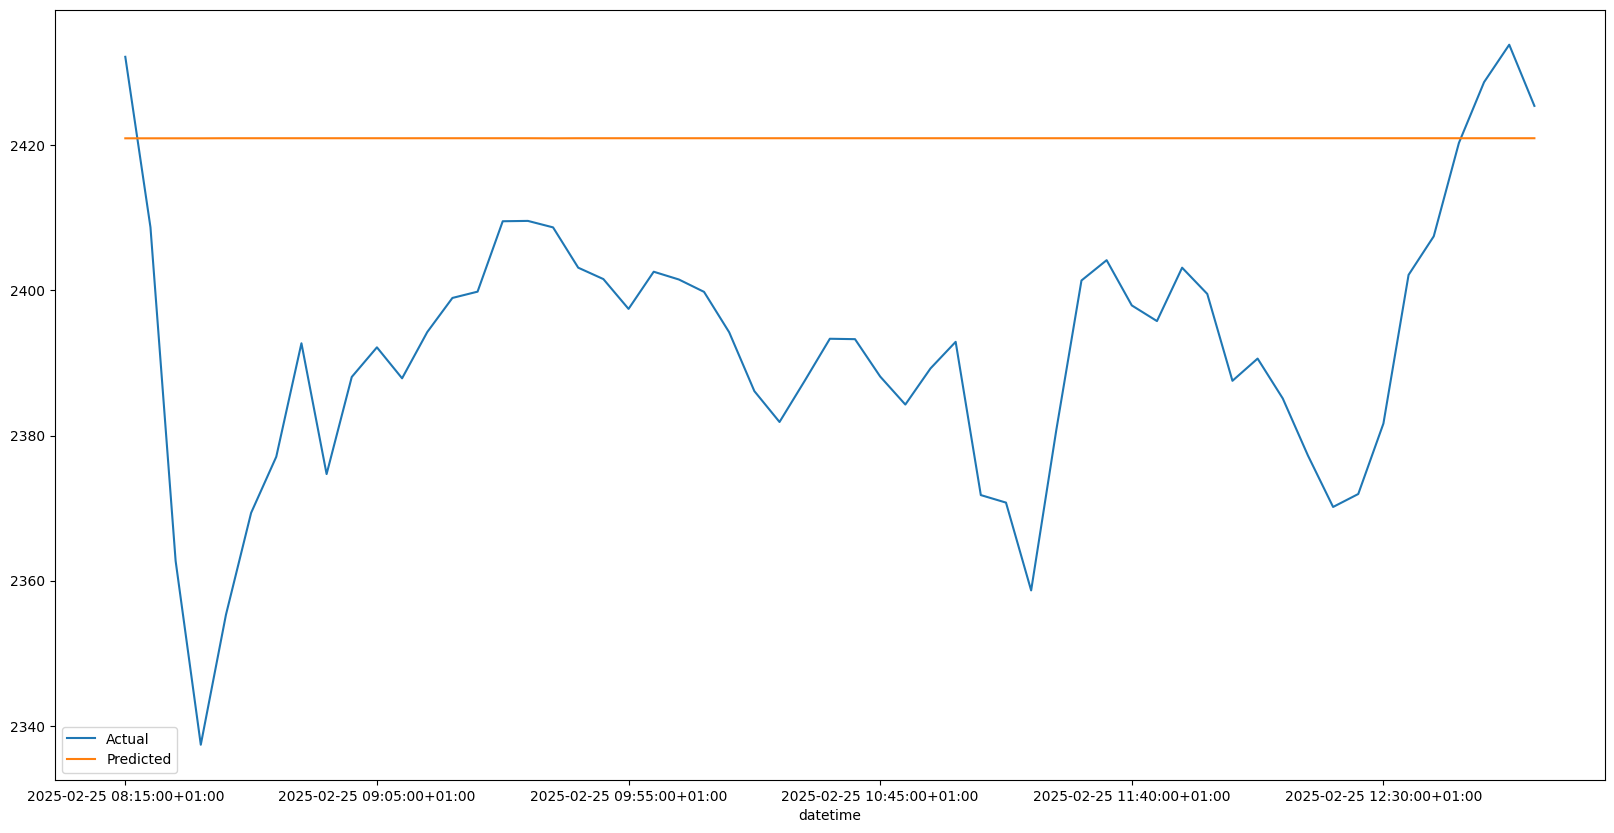

In [ ]:
# Dask Example:Final Model Results, Evaluation, & Visualisation
y_test= y_test.compute()
predictions= pd.Series(predictions.compute(), index=y_test.index)
r2 = r2_score(y_true=y_test, y_pred=predictions)
std = y_test.std()
score = study.best_value
Thresh_var = score/std 
print('Standard_Dev: '+ f'{std}')
print(f"Best parameters: {study.best_params}")
print(f"Best MAPE: {study.best_value}")
print(f"R2 Score: {r2}")
# print(f'Score/Std: {Thresh_var}')
viz = pd.concat([y_test, predictions],axis=1)
viz.columns = ['Actual', 'Predicted']
viz.plot(figsize=(20,10))

Feature Extraction: 100%|██████████| 96/96 [00:28<00:00,  3.42it/s]


enough_sig_feat


variable,total_volumes ethereum__length,prices,total_volumes ethereum__standard_deviation,prices__maximum,total_volumes ethereum__maximum,prices ethereum,total_volumes__root_mean_square,prices ethereum__mean,market_caps ethereum__root_mean_square,prices__variance,...,total_volumes ethereum__minimum,prices ethereum__length,market_caps__maximum,total_volumes__standard_deviation,total_volumes__length,market_caps ethereum__standard_deviation,market_caps__absolute_maximum,total_volumes__mean,1PeriodVol(%),market_caps ethereum__minimum
datetime,,,,,,,,,,,,,,,,,,,,,
2025-02-24 13:15:00+01:00,1.0,95871.913727,0.000000e+00,95871.913727,2.526782e+10,2688.170321,2.550143e+10,2688.170321,3.237378e+11,0.000000e+00,...,2.526782e+10,1.0,1.900137e+12,0.000000e+00,1.0,0.000000e+00,1.900137e+12,2.550143e+10,0.381814,3.237378e+11
2025-02-24 13:30:00+01:00,2.0,95969.419685,4.774883e+07,95969.419685,2.526782e+10,2689.888043,2.547396e+10,2689.029182,3.240278e+11,2.376853e+03,...,2.517232e+10,2.0,1.900669e+12,2.748804e+07,2.0,2.899222e+08,1.900669e+12,2.547394e+10,0.063879,3.237378e+11
2025-02-24 13:45:00+01:00,3.0,95790.010062,4.911649e+07,95969.419685,2.528344e+10,2682.208935,2.399496e+10,2686.755767,3.238561e+11,5.378159e+03,...,2.517232e+10,3.0,1.900669e+12,2.239870e+09,3.0,3.391967e+08,1.900669e+12,2.389019e+10,0.285889,3.235123e+11
2025-02-24 14:00:00+01:00,4.0,95587.679164,5.625606e+07,95969.419685,2.528344e+10,2673.132820,2.375415e+10,2683.350030,3.234439e+11,1.974102e+04,...,2.515617e+10,4.0,1.900669e+12,1.976326e+09,4.0,7.732337e+08,1.900669e+12,2.367179e+10,0.338956,3.222041e+11
2025-02-24 14:15:00+01:00,5.0,95901.034174,1.117437e+09,95969.419685,2.528344e+10,2683.418095,2.344550e+10,2683.363643,3.234957e+11,1.727595e+04,...,2.242918e+10,5.0,1.902906e+12,1.867221e+09,5.0,6.993662e+08,1.902906e+12,2.337103e+10,0.384027,3.222041e+11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-25 11:45:00+01:00,91.0,88134.512077,4.975997e+09,95997.508108,4.117538e+10,2403.143335,4.582448e+10,2555.276779,3.084022e+11,4.616942e+06,...,2.207851e+10,91.0,1.903548e+12,1.390618e+10,91.0,1.244581e+10,1.903548e+12,4.366350e+10,0.043058,2.833761e+11
2025-02-25 12:00:00+01:00,92.0,88138.055096,5.076735e+09,95997.508108,4.117538e+10,2390.616438,4.614279e+10,2553.486993,3.081839e+11,4.790574e+06,...,2.207851e+10,92.0,1.903548e+12,1.408221e+10,92.0,1.255973e+10,1.903548e+12,4.394142e+10,0.522635,2.833761e+11
2025-02-25 12:15:00+01:00,93.0,87846.276665,5.181250e+09,95997.508108,4.158651e+10,2370.164730,4.660309e+10,2551.515786,3.079597e+11,4.984630e+06,...,2.207851e+10,93.0,1.903548e+12,1.444253e+10,93.0,1.268433e+10,1.903548e+12,4.430871e+10,0.859180,2.833761e+11


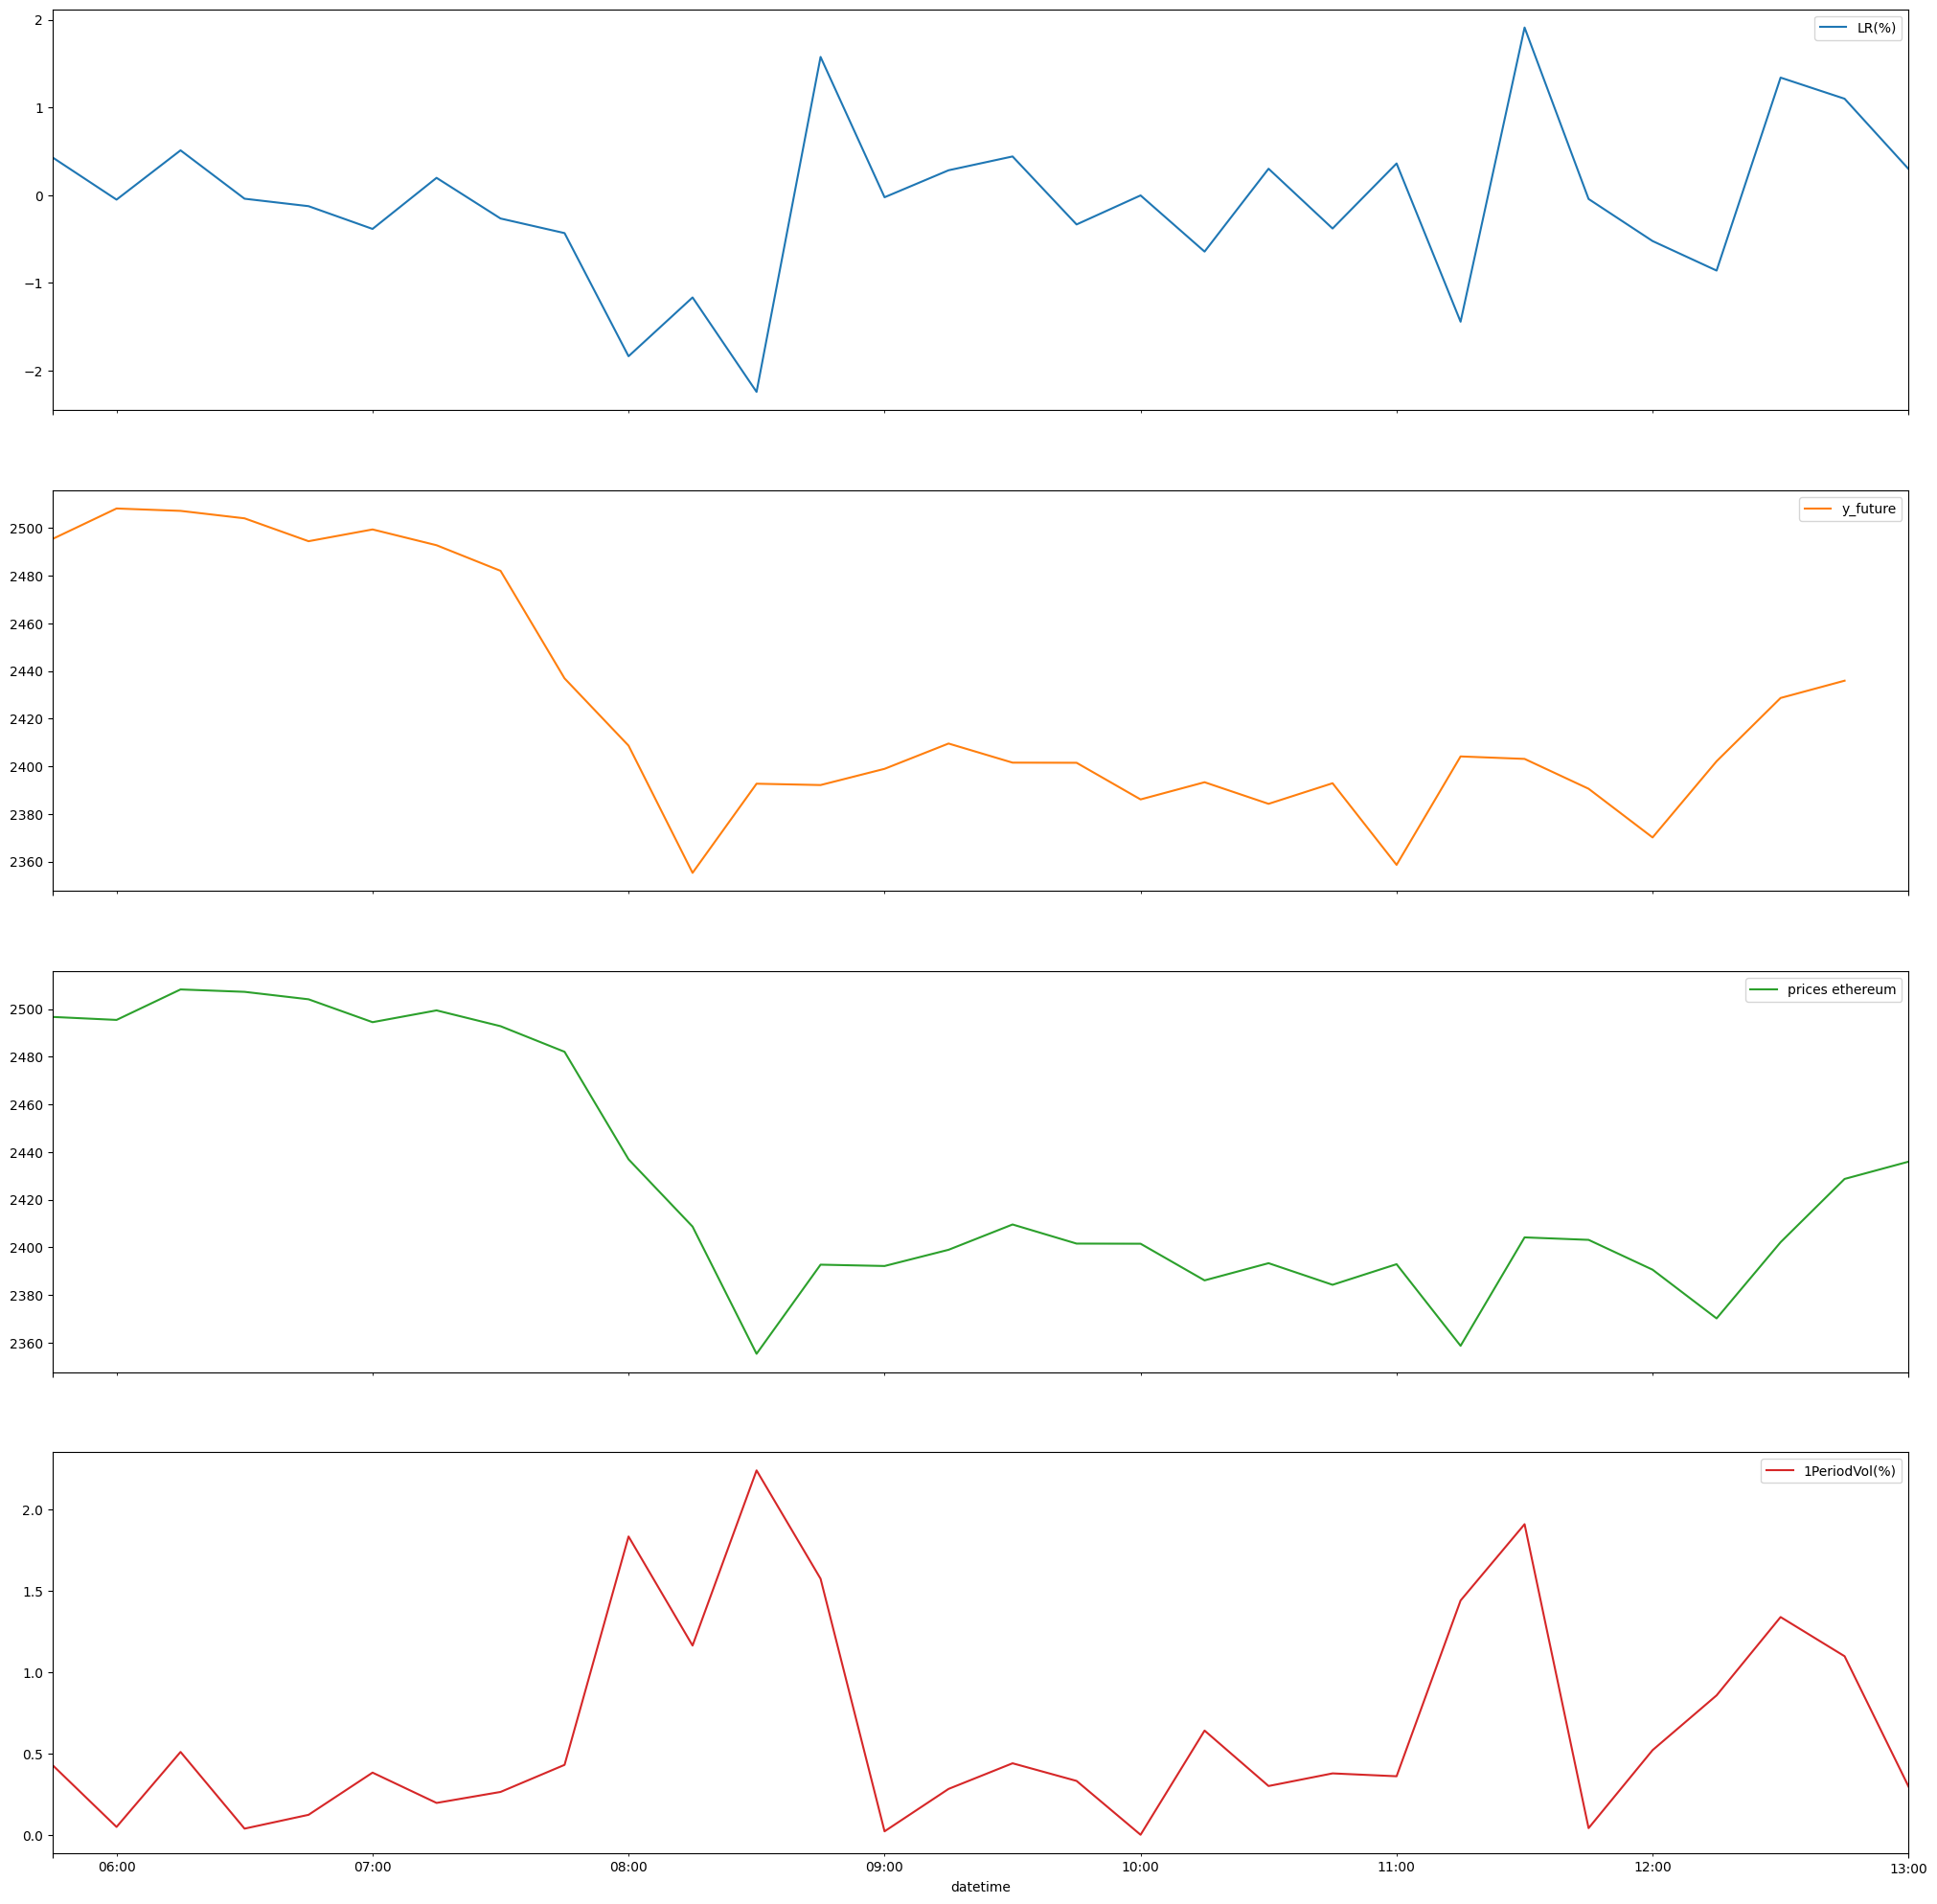

In [ ]:
# Pandas Example 1-Pandas with Multiprocessing Distributor: 
# Raw Data, Feature Extraction & Selection, Visualization Results
df_pandas= My_API_Wraps.CoinGecko_HSPD_Pandas(timeframe, top_coins, periods, api_key)
EF_pandas= My_FE_Wraps.EF_Pandas_MultiprocessingDistributor(df_pandas, ParameterComplexity=0)
SF_pandas= My_FS_Wraps.SF_Pandas_v1(EF_pandas)
SF_pandas

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[0]	validation_0-mae:11.48715
[1]	validation_0-mae:8.00291
[2]	validation_0-mae:6.81204
[3]	validation_0-mae:6.12551
[4]	validation_0-mae:5.19421
[5]	validation_0-mae:4.73070
[6]	validation_0-mae:4.32597
[7]	validation_0-mae:3.95745
[8]	validation_0-mae:3.52234
[9]	validation_0-mae:3.20472
[10]	validation_0-mae:2.94608
[11]	validation_0-mae:2.74348
[12]	validation_0-mae:2.58369
[13]	validation_0-mae:2.33556
[14]	validation_0-mae:2.25171
[15]	validation_0-mae:2.08370
[16]	validation_0-mae:1.88996
[17]	validation_0-mae:1.70019
[18]	validation_0-mae:1.60616
[19]	validation_0-mae:1.52064
[20]	validation_0-mae:1.38683
[21]	validation_0-mae:1.33404
[22]	validation_0-mae:1.26697
[23]	validation_0-mae:1.21385
[24]	validation_0-mae:1.12165
[25]	validation_0-mae:0.99958
[26]	validation_0-mae:0.94357
[27]	validation_0-mae:0.88336
[28]	validation_0-mae:0.84408
[29]	validation_0-mae:0.77383
[30]	validation_0-mae:0.73400
[31]	validation_0

,f_imp
total_volumes ethereum__maximum,0.585378
total_volumes ethereum__length,0.278245
prices,0.091838
total_volumes ethereum__standard_deviation,0.004924
total_volumes__root_mean_square,0.004763
...,...
total_volumes ethereum__minimum,0.000000
total_volumes__length,0.000000
market_caps__maximum,0.000000
market_caps__absolute_maximum,0.000000


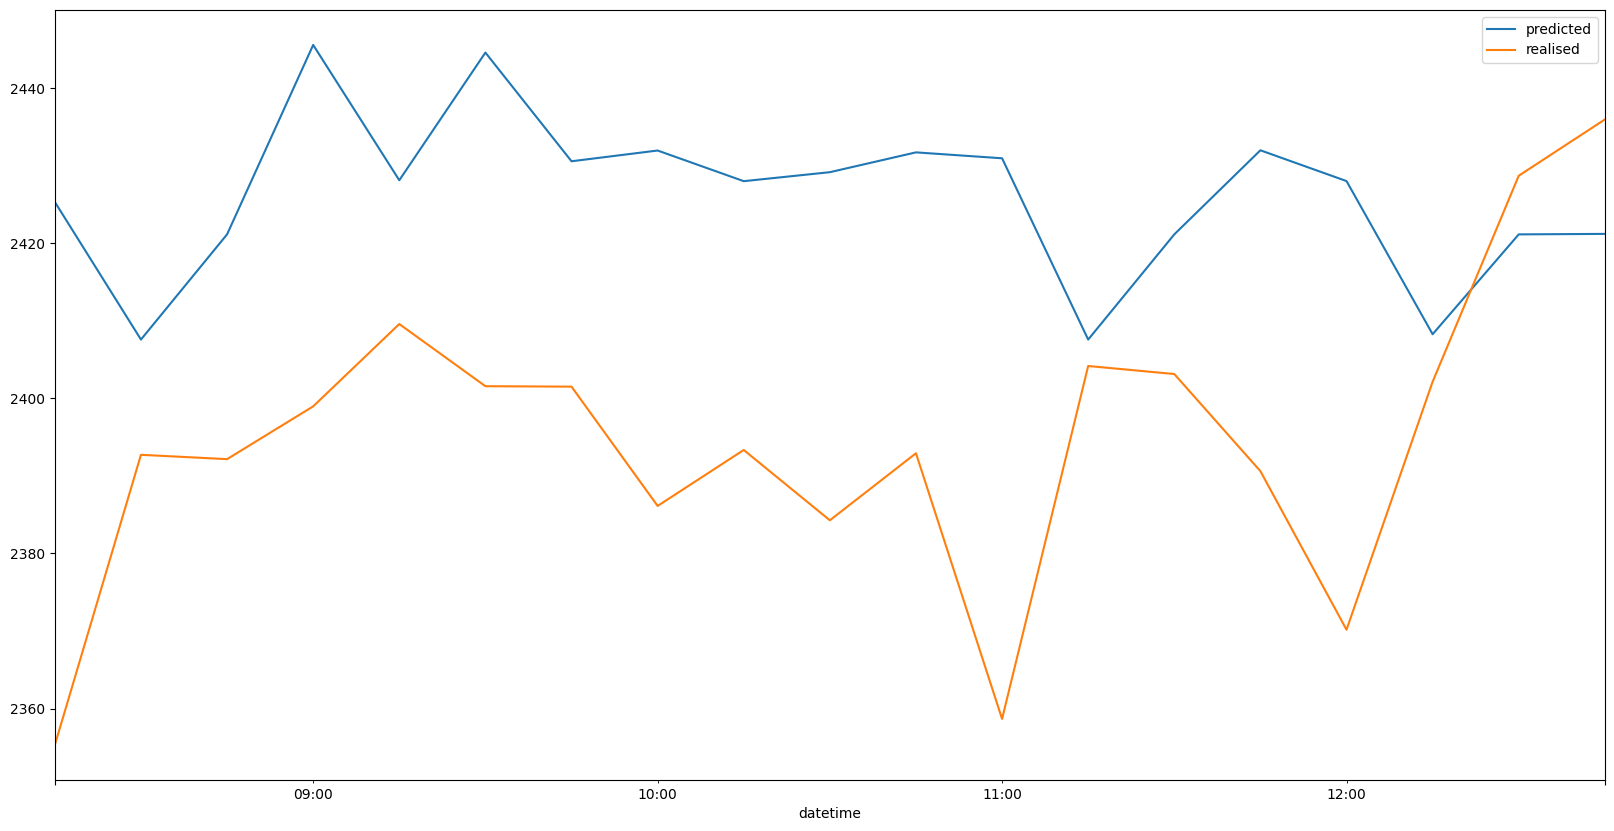

In [ ]:
# Pandas Example 1-Pandas with Multiprocessing Distributor: 
# Train-Test Split, XGBoost Hyperparameter Optimization & Model Training, Evaluation, & Visualisation
X= SF_pandas.drop('y_future', axis=1)
y= SF_pandas['y_future']
X_train = X.iloc[:int(-0.2*len(SF_pandas))]
y_train = y.iloc[:int(-0.2*len(SF_pandas))]
X_test = X.iloc[int(-0.2*len(SF_pandas)):]
y_test = y.iloc[int(-0.2*len(SF_pandas)):]
RGS= My_ML_Wraps.RGS_XGB_Pandas(X_train, X_test, y_train, y_test, parameter_grid=None, number_cvs=5)
final_model= RGS.best_estimator_
final_model= final_model.fit(X_train, y_train, eval_set=[(X_train, y_train)])
preds=final_model.predict(X_test)
r2= final_model.score(X_test, y_test)
predictions = pd.DataFrame(preds, columns= ['predicted'], index= X_test.index)
predictions['realised']= y_test.values
predictions.plot(figsize=(20,10))
score = RGS.best_score_
std = y_test.std()
print('RGS Best Score: '+ f'{score}')
print('Y_test Standard_Dev: '+ f'{std}')
print(f'R2: {r2}')
feature_imp = pd.DataFrame(data = final_model.feature_importances_, index= final_model.feature_names_in_, columns=['f_imp']).sort_values(ascending=False, by='f_imp')
Thresh_var = score/std 
print(f'score/std: {Thresh_var}')
display(feature_imp)

enough_sig_feat


variable,total_volumes__c3__lag_2,"total_volumes__agg_linear_trend__attr_""slope""__chunk_len_10__f_agg_""var""",total_volumes__quantile__q_0.8,"total_volumes ethereum__agg_linear_trend__attr_""intercept""__chunk_len_10__f_agg_""max""",market_caps__large_standard_deviation__r_0.35000000000000003,prices__mean_abs_change,market_caps ethereum__ar_coefficient__coeff_3__k_10,prices__partial_autocorrelation__lag_4,"total_volumes__fft_coefficient__attr_""abs""__coeff_9","market_caps ethereum__change_quantiles__f_agg_""mean""__isabs_True__qh_0.8__ql_0.2",...,"market_caps ethereum__fft_aggregated__aggtype_""kurtosis""",total_volumes ethereum__absolute_maximum,"prices ethereum__change_quantiles__f_agg_""var""__isabs_True__qh_1.0__ql_0.4","total_volumes ethereum__fft_coefficient__attr_""abs""__coeff_15","total_volumes ethereum__fft_coefficient__attr_""imag""__coeff_4","total_volumes ethereum__cwt_coefficients__coeff_9__w_2__widths_(2, 5, 10, 20)","market_caps__agg_autocorrelation__f_agg_""mean""__maxlag_40","prices ethereum__change_quantiles__f_agg_""var""__isabs_False__qh_0.8__ql_0.2","market_caps__cwt_coefficients__coeff_1__w_2__widths_(2, 5, 10, 20)","prices ethereum__change_quantiles__f_agg_""mean""__isabs_False__qh_0.6__ql_0.2"
datetime,,,,,,,,,,,,,,,,,,,,,
2025-02-24 13:15:00+01:00,0.000000e+00,1.710188e+18,2.550143e+10,2.490866e+10,0.0,261.222379,0.351791,-0.067910,3.261022e+10,0.000000e+00,...,69.744655,2.526782e+10,0.000000,1.104614e+10,1.919898e+10,7.779820e+08,0.000000,0.000000,1.058601e+12,0.000000
2025-02-24 13:30:00+01:00,0.000000e+00,1.710188e+18,2.549043e+10,2.490866e+10,1.0,97.505958,0.351791,-0.067910,3.261022e+10,0.000000e+00,...,69.744655,2.526782e+10,0.000000,1.104614e+10,1.919898e+10,7.779820e+08,-1.000000,0.000000,2.118079e+12,0.000000
2025-02-24 13:45:00+01:00,0.000000e+00,1.710188e+18,2.547944e+10,2.490866e+10,1.0,138.457791,0.351791,-0.067910,3.261022e+10,0.000000e+00,...,69.744655,2.528344e+10,0.000000,1.104614e+10,1.919898e+10,7.779820e+08,-0.401247,0.000000,2.708009e+12,0.000000
2025-02-24 14:00:00+01:00,0.000000e+00,1.710188e+18,2.546844e+10,2.490866e+10,1.0,159.748826,0.351791,-0.067910,3.261022e+10,0.000000e+00,...,69.744655,2.528344e+10,0.000000,1.104614e+10,1.919898e+10,7.779820e+08,-0.511483,0.000000,2.502790e+12,0.000000
2025-02-24 14:15:00+01:00,1.171486e+31,1.710188e+18,2.545745e+10,2.490866e+10,0.0,198.150372,0.351791,-0.067910,3.261022e+10,0.000000e+00,...,69.744655,2.528344e+10,0.000000,1.104614e+10,1.919898e+10,7.779820e+08,-0.117527,0.000000,2.708009e+12,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-02-25 12:00:00+01:00,1.064219e+32,2.298692e+18,5.503026e+10,2.423296e+10,0.0,297.635785,-0.013885,-0.154341,8.370521e+10,1.394318e+09,...,43.189831,4.117538e+10,92.735836,2.363635e+10,6.894063e+10,7.779820e+08,0.376154,208.647126,1.058601e+12,-2.639617
2025-02-25 12:15:00+01:00,1.100742e+32,2.424395e+18,5.525755e+10,2.417316e+10,0.0,297.572118,-0.028124,0.020735,8.434058e+10,1.410211e+09,...,44.302862,4.158651e+10,91.661521,2.536732e+10,7.031758e+10,7.779820e+08,0.380518,205.544695,1.058601e+12,-2.885250
2025-02-25 12:30:00+01:00,1.126800e+32,2.863511e+18,5.590093e+10,2.396751e+10,0.0,303.688947,-0.011953,0.013840,8.962875e+10,1.437669e+09,...,46.431297,4.300035e+10,91.661521,2.402268e+10,7.178913e+10,7.779820e+08,0.386211,218.197237,1.058601e+12,-2.904893


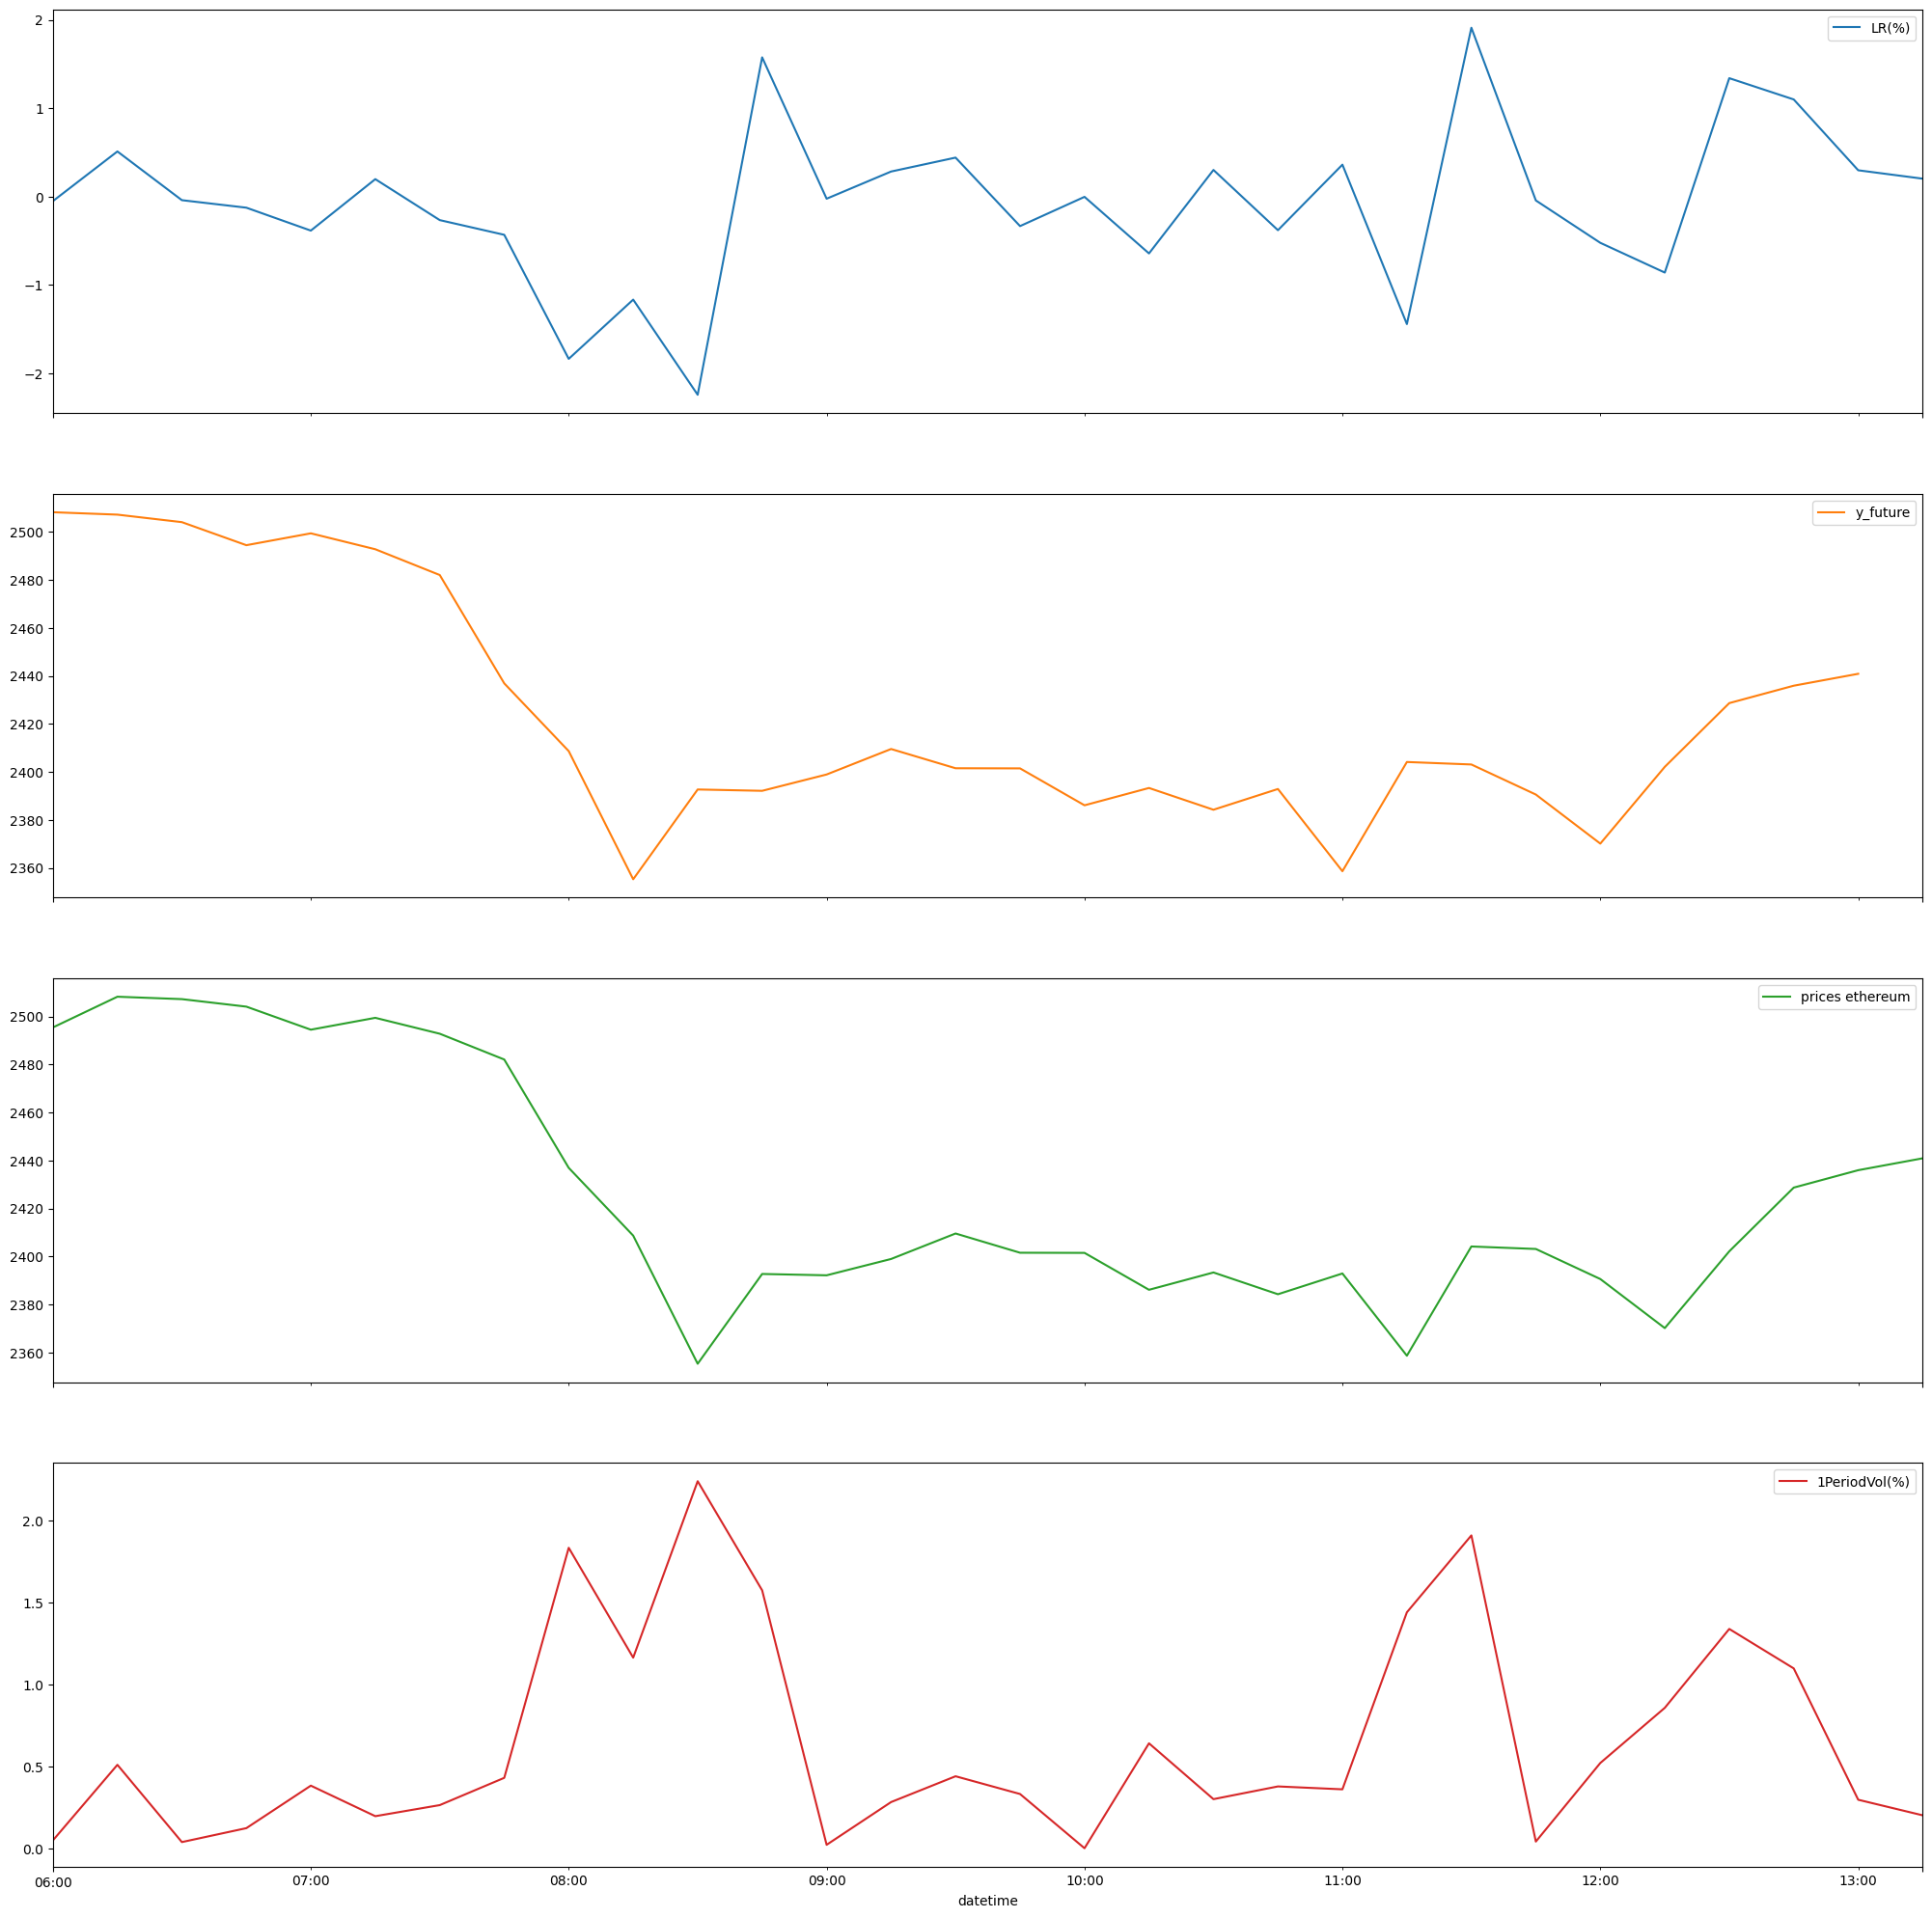

In [ ]:
# Pandas Example 2-Pandas with Dask Distributor: 
# Raw Data, Feature Extraction & Selection, Visualization Results
df_pandas2= My_API_Wraps.CoinGecko_HSPD_Pandas(timeframe, top_coins, periods, api_key)
EF_pandas2= My_FE_Wraps.EF_Pandas_DaskDistributor(df_pandas2, cluster.scheduler_address, ParameterComplexity=1)
SF_pandas2= My_FS_Wraps.SF_Pandas_v1(EF_pandas2)
SF_pandas2

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[0]	validation_0-mae:12.34976
[1]	validation_0-mae:5.16752
[2]	validation_0-mae:2.78651
[3]	validation_0-mae:1.62811
[4]	validation_0-mae:1.27249
[5]	validation_0-mae:1.03891
[6]	validation_0-mae:0.86059
[7]	validation_0-mae:0.68688
[8]	validation_0-mae:0.56772
[9]	validation_0-mae:0.49299
[10]	validation_0-mae:0.42354
[11]	validation_0-mae:0.34424
[12]	validation_0-mae:0.33397
[13]	validation_0-mae:0.29982
[14]	validation_0-mae:0.28284
[15]	validation_0-mae:0.26991
[16]	validation_0-mae:0.23545
[17]	validation_0-mae:0.22586
[18]	validation_0-mae:0.19331
[19]	validation_0-mae:0.16683
[20]	validation_0-mae:0.16777
[21]	validation_0-mae:0.16777
[22]	validation_0-mae:0.16777
[23]	validation_0-mae:0.16777
[24]	validation_0-mae:0.16777
[25]	validation_0-mae:0.16777
[26]	validation_0-mae:0.16777
[27]	validation_0-mae:0.16777
[28]	validation_0-mae:0.16777
[29]	validation_0-mae:0.16777
[30]	validation_0-mae:0.16777
[31]	validation_0

,f_imp
total_volumes__quantile__q_0.8,0.546038
total_volumes__c3__lag_2,0.364036
"market_caps ethereum__change_quantiles__f_agg_""var""__isabs_True__qh_0.4__ql_0.0",0.010922
"market_caps__change_quantiles__f_agg_""mean""__isabs_True__qh_1.0__ql_0.2",0.010922
"prices ethereum__fft_aggregated__aggtype_""variance""",0.008815
...,...
prices__energy_ratio_by_chunks__num_segments_10__segment_focus_0,0.000000
"prices__augmented_dickey_fuller__attr_""teststat""__autolag_""AIC""",0.000000
"total_volumes__agg_linear_trend__attr_""stderr""__chunk_len_10__f_agg_""mean""",0.000000
"total_volumes__agg_linear_trend__attr_""rvalue""__chunk_len_10__f_agg_""min""",0.000000


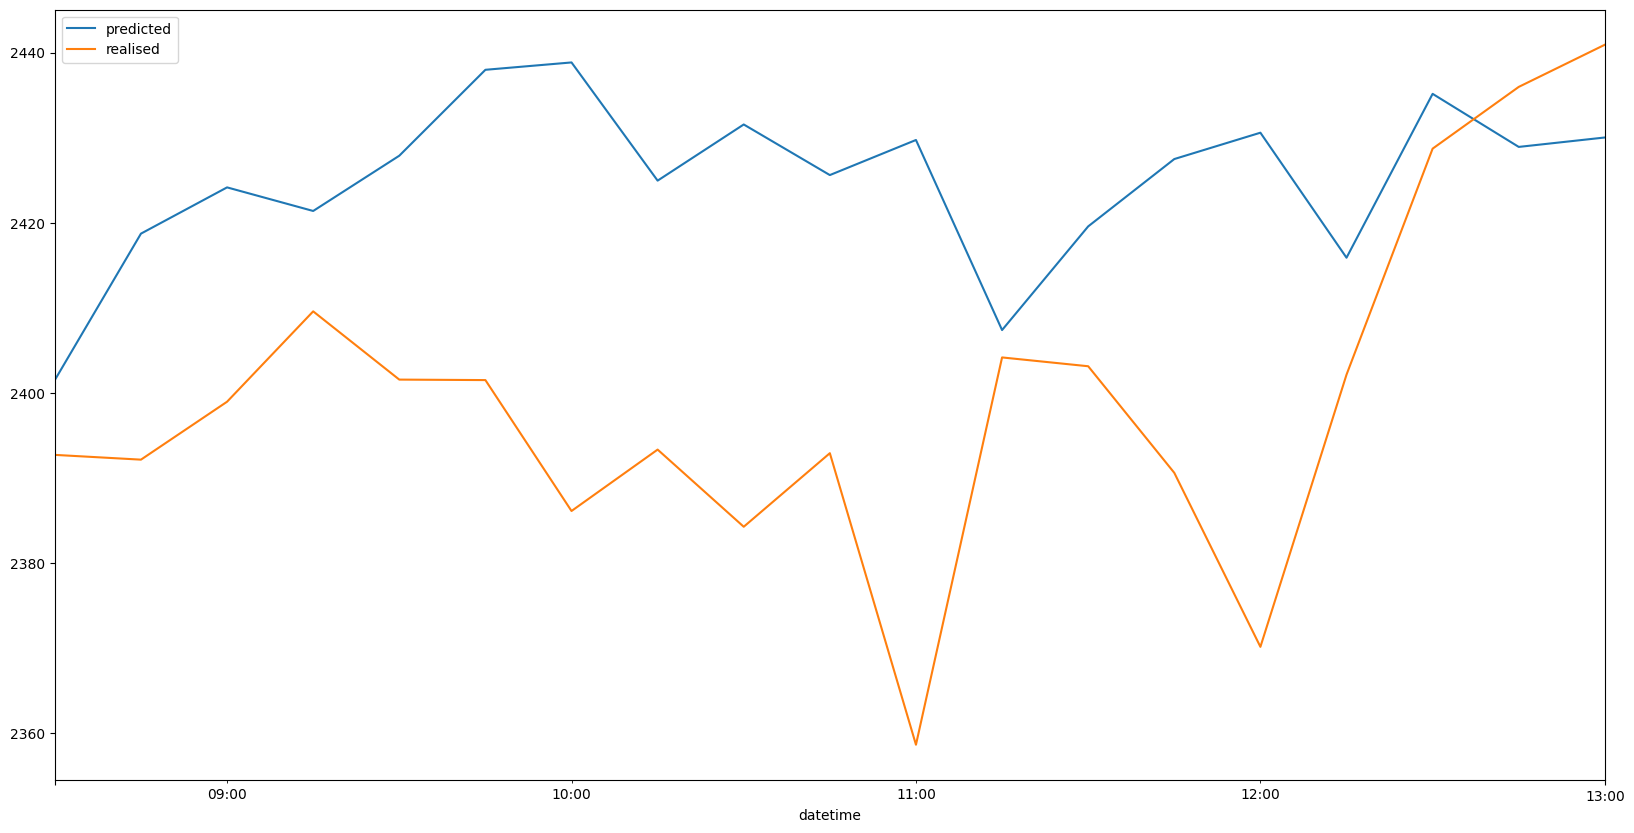

In [ ]:
# Pandas Example 2-Pandas with Dask Distributor: 
# Train-Test Split, XGBoost Hyperparameter Optimization & Model Training, Evaluation, & Visualisation
X= SF_pandas2.drop('y_future', axis=1)
y= SF_pandas2['y_future']
X_train = X.iloc[:int(-0.2*len(SF_pandas2))]
y_train = y.iloc[:int(-0.2*len(SF_pandas2))]
X_test = X.iloc[int(-0.2*len(SF_pandas2)):]
y_test = y.iloc[int(-0.2*len(SF_pandas2)):]
RGS= My_ML_Wraps.RGS_XGB_Pandas(X_train, X_test, y_train, y_test, parameter_grid=None, number_cvs=5)
final_model= RGS.best_estimator_
final_model= final_model.fit(X_train, y_train, eval_set=[(X_train, y_train)])
preds=final_model.predict(X_test)
r2= final_model.score(X_test, y_test)
predictions = pd.DataFrame(preds, columns= ['predicted'], index= X_test.index)
predictions['realised']= y_test.values
predictions.plot(figsize=(20,10))
score = RGS.best_score_
std = y_test.std()
print('RGS Best Score: '+ f'{score}')
print('Y_test Standard_Dev: '+ f'{std}')
print(f'R2: {r2}')
feature_imp = pd.DataFrame(data = final_model.feature_importances_, index= final_model.feature_names_in_, columns=['f_imp']).sort_values(ascending=False, by='f_imp')
Thresh_var = score/std 
print(f'score/std: {Thresh_var}')
display(feature_imp)

In [ ]:
# Pandas- Final model for deployment and plot of predicted, realised, and untested future predictions
final_model = xgb.XGBRegressor(tree_method='hist',**RGS.best_params_)
final_model.fit(X, y)
deployment_preds= features.drop('y_future', axis=1)[X.columns].tail(shift)
dep_preds=final_model.predict(deployment_preds)
dep_preds= pd.Series(dep_preds, index=deployment_preds.index.shift(freq=freq), name='untested_predictions')
predictions.join(dep_preds, how='outer').plot()

In [ ]:
# Work in Progress-  Using PancakeSwap API to set up trading bot 
# import requests
# import json

# # Replace with your PancakeSwap API endpoint and API key
API_ENDPOINT = 'https://api.pancakeswap.info/api/v2/orders'
API_KEY = 'your_api_key_here'

def place_order(order_type, amount, leverage, price=None):
    headers = {
        'Content-Type': 'application/json',
        'Authorization': f'Bearer {API_KEY}'
    }
    order_data = {
        'type': order_type,  # 'buy' or 'sell'
        'amount': amount,    # Amount of ETH to trade
        'leverage': leverage # Leverage to use
    }
    if price:
        order_data['price'] = price  # Set price for limit orders
    else:
        order_data['price'] = 'market'  # Set price to market for market orders

    response = requests.post(API_ENDPOINT, headers=headers, data=json.dumps(order_data))
    if response.status_code == 200:
        print(f"Order placed successfully: {response.json()}")
    else:
        print(f"Failed to place order: {response.status_code}, {response.text}")

# Example usage
place_order('buy', 0.1, 10)  # Place a market buy order for 0.1 ETH with 10x leverage
place_order('sell', 0.1, 10, 3600.10)  # Place a limit sell order for 0.1 ETH at $3600.10 with 10x leverage
# In this example, if you don't provide a price, the order will be placed at the market price. If you provide a price, it will be treated as a limit order. This way, you can easily switch between market and limit orders based on your trading strategy. Happy trading!


def execute_trade(prediction): 
    if prediction >= 0.02: 
        place_order('buy', 0.1, 10)  # Place a buy order for 0.1 ETH at $3600.10 with 10x leverage
    elif prediction <= -0.02:
        place_order('sell', 0.1, 10)

# # Main trading loop
# while True:
#     market_data = fetch_market_data()
#     prediction = make_prediction(market_data)
#     execute_trade(prediction)
#     # Sleep for 30 minutes before making the next prediction
#     time.sleep(1800)

